# Claim Severity Modelling

## Intro

Here I try to use GLMs to model claim frequency. Unfortunately, I can't tell if this is a good model or not. RMSE for submissions online
is usually around 499. I'm running at a lot higher.

## Method

I break the claims into three categories;
- Minor claims
- Major claims
- Large loss (ultra) claims

## Results

### General Discussion

So a large number of the obvious fields to use don't actually produce any predictability what-so-ever. This includes driver age, presence of an additional driver under 30 etc.

### Minor Claims

### Major Claims

### Large Losses

These are too few in number to model, what I plan to do is sum the total incurred for these claims and divide it by the number of policies that 
were written. This will then be added onto the premium for each policy.

In [ ]:
from math import floor

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import TweedieRegressor, GammaRegressor 
from sklearn import tree # https://scikit-learn.org/stable/modules/tree.html

# A very easy to follow tutorial for exactly what we're doing!
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py


In [39]:
# Some very nice functions I found in the tutorial linked above

def plot_obs_pred(df, feature, weight, observed, predicted, y_label=None,
                  title=None, ax=None, fill_legend=False):
    """Plot observed and predicted - aggregated per feature level.

    Remember to declare figure first with the below;
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
        fig.subplots_adjust(hspace=0.3, wspace=0.2)       
        
    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )

def score_estimator(estimator, X_train, X_test, df_train, df_test, target, weights,
    tweedie_powers=None):

    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [(
            "mean Tweedie dev p={:.4f}".format(power),
            partial(mean_tweedie_deviance, power=power)
        ) for power in tweedie_powers]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res

def get_dummies(series):
    '''
    Get Dummies

    This one is mine, it tried to 'one hot' encode the categorical variables.
    '''
    dummyframe = pd.DataFrame()
    name = series.name
    for x in series.unique():
        dummyframe[f"{name}_{x}"] = [1 if item == x else 0 for item in series]
    return dummyframe

In [40]:
raw_data = pd.read_csv(r"C:\Users\Dev Work\Documents\aicrowd\insurancepricing\python\training.csv")

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228216 entries, 0 to 228215
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_policy               228216 non-null  object 
 1   year                    228216 non-null  int64  
 2   pol_no_claims_discount  228216 non-null  float64
 3   pol_coverage            228216 non-null  object 
 4   pol_duration            228216 non-null  int64  
 5   pol_sit_duration        228216 non-null  int64  
 6   pol_pay_freq            228216 non-null  object 
 7   pol_payd                228216 non-null  object 
 8   pol_usage               228216 non-null  object 
 9   drv_sex1                228216 non-null  object 
 10  drv_age1                228216 non-null  int64  
 11  drv_age_lic1            228216 non-null  int64  
 12  drv_drv2                228216 non-null  object 
 13  drv_sex2                228216 non-null  object 
 14  drv_age2            

In [60]:
# Data Preprocessing
raw_data = pd.read_csv(r"C:\Users\Dev Work\Documents\aicrowd\insurancepricing\python\training.csv")

# Bools
raw_data['drv_drv2'] = [1 if x == 'Yes' else 0 for x in raw_data['drv_drv2']]
raw_data['drv_drv2_young_driver'] = [1 if age <= 25 else 0 for age in raw_data['drv_age2']]

# label encoding
# keep the dummy frames for later, we can use .columns to get a list of one hot column names easily.
dummy_pol_coverage = get_dummies(raw_data['pol_coverage'])
dummy_pol_pay_freq = get_dummies(raw_data['pol_pay_freq'])
dummy_pol_usage    = get_dummies(raw_data['pol_usage'])
dummy_drv_sex1     = get_dummies(raw_data['drv_sex1'])

raw_data = raw_data.join(dummy_pol_coverage)
raw_data = raw_data.join(dummy_pol_pay_freq)
raw_data = raw_data.join(dummy_pol_usage)
raw_data = raw_data.join(dummy_drv_sex1)

# Here we create the datasets themselves
policies_with_claims = raw_data['claim_amount'] > 0
data = raw_data[policies_with_claims]

claims_minor = data[(data['claim_amount'] >= 60) & (data['claim_amount'] < 160)]
claims_major = data[(data['claim_amount'] >= 160) & (data['claim_amount'] < 8000)]
claims_ultra = data[data['claim_amount'] >= 8000]

In [61]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228216 entries, 0 to 228215
Data columns (total 41 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_policy               228216 non-null  object 
 1   year                    228216 non-null  int64  
 2   pol_no_claims_discount  228216 non-null  float64
 3   pol_coverage            228216 non-null  object 
 4   pol_duration            228216 non-null  int64  
 5   pol_sit_duration        228216 non-null  int64  
 6   pol_pay_freq            228216 non-null  object 
 7   pol_payd                228216 non-null  object 
 8   pol_usage               228216 non-null  object 
 9   drv_sex1                228216 non-null  object 
 10  drv_age1                228216 non-null  int64  
 11  drv_age_lic1            228216 non-null  int64  
 12  drv_drv2                228216 non-null  int64  
 13  drv_sex2                228216 non-null  object 
 14  drv_age2            

In [43]:
data.head()

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,...,pol_pay_freq_Monthly,pol_pay_freq_Yearly,pol_pay_freq_Quarterly,pol_pay_freq_Biannual,pol_usage_WorkPrivate,pol_usage_Retired,pol_usage_Professional,pol_usage_AllTrips,drv_sex1_M,drv_sex1_F
14,PL042479,1,0.000,Max,5,2,Biannual,No,WorkPrivate,M,...,0,0,0,1,1,0,0,0,1,0
15,PL042480,1,0.000,Max,27,3,Yearly,No,Retired,F,...,0,1,0,0,0,1,0,0,0,1
20,PL042488,1,0.428,Med2,4,4,Biannual,No,Retired,M,...,0,0,0,1,0,1,0,0,1,0
31,PL042548,1,0.000,Max,2,2,Biannual,No,Professional,F,...,0,0,0,1,0,0,1,0,0,1
45,PL042474,1,0.000,Max,26,2,Biannual,No,WorkPrivate,F,...,0,0,0,1,1,0,0,0,0,1


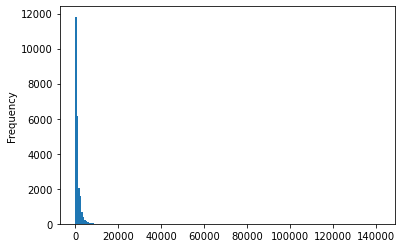

In [44]:
data['claim_amount'].plot(kind="hist", bins=200)

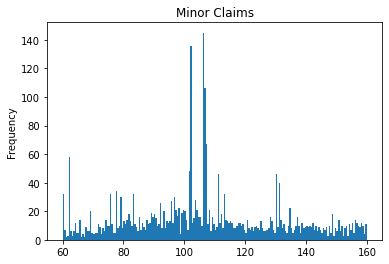

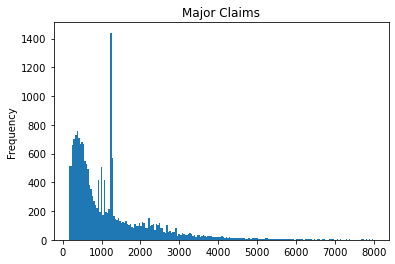

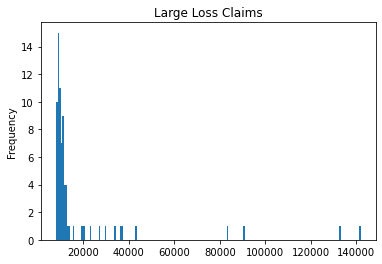

In [45]:
claims_minor['claim_amount'].plot(kind="hist", bins=200, title="Minor Claims")
plt.show()
claims_major['claim_amount'].plot(kind="hist", bins=200, title="Major Claims")
plt.show()
claims_ultra['claim_amount'].plot(kind="hist", bins=200, title="Large Loss Claims")
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

class ClaimModel():
    '''
    Helper class to keep track of model attributes and datasets. Inputs; model, dataset, target, features.

    '''
    
    def __init__(self, model, dataset, target=None, features=None):
        

        self.model = model
        self.dataset = dataset
        self.features = features
        self.target = target

        self._y = dataset[target]
        self._x = dataset[features]

        self.splitData()

    def splitData(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self._x, self._y)
        self._train_index = self.x_train.index
        self._test_index = self.x_test.index
        self.train = self.dataset[self.dataset.index.isin(self._train_index)]
        self.test = self.dataset[self.dataset.index.isin(self._test_index)]

    def fit(self, *args, **kwargs):
        self.model.fit(self.x_train, self.y_train, *args, **kwargs)
    
    def predict(self, *args, **kwargs):
        self.predictions = self.model.predict(self.x_test, *args, **kwargs)
        self.results = pd.DataFrame({
                            "Actual":self.y_test, 
                            "Predictions":self.predictions,
                            "Residuals":self.predictions - self.y_test,
                            "Residuals_Squared":((self.predictions - self.y_test)**2)**0.5
                            })
        return self.predictions

    def plot(self,**kwargs):
        plot_obs_pred(df=self.test, predicted=self.predict(), **kwargs)


In [62]:
minor_model = TweedieRegressor(power=0, link='log')
major_model = GammaRegressor(alpha=10.,max_iter=10000)
ultra_model = TweedieRegressor(power=2, link='log')

features = ['pol_sit_duration', 'pol_duration', 'drv_age1', 'drv_drv2_young_driver']

features = [*features, *dummy_pol_coverage.columns]
features = [*features, *dummy_pol_pay_freq.columns]
features = [*features, *dummy_pol_usage.columns]
features = [*features, *dummy_drv_sex1.columns]

minor = ClaimModel(minor_model, claims_minor, target='claim_amount', features=features)
major = ClaimModel(major_model, claims_major, target='claim_amount', features=features)
ultra = ClaimModel(ultra_model, claims_ultra, target='claim_amount', features=features)

models = [major]

In [67]:
for model in models:
    model.fit()
    model.predict()

print(major.results)

         Actual  Predictions   Residuals  Residuals_Squared
170364   487.73  1175.031758  687.301758         687.301758
138363   532.63  1192.199185  659.569185         659.569185
10311   1213.48  1225.541967   12.061967          12.061967
40143   1131.60  1232.203879  100.603879         100.603879
114692   306.82  1213.479362  906.659362         906.659362
...         ...          ...         ...                ...
66442   1359.62  1325.371293  -34.248707          34.248707
188622  1276.00  1230.723271  -45.276729          45.276729
56688   1117.61  1306.801481  189.191481         189.191481
146642  1063.77  1243.220964  179.450964         179.450964
165686  1115.95  1298.872795  182.922795         182.922795

[4988 rows x 4 columns]


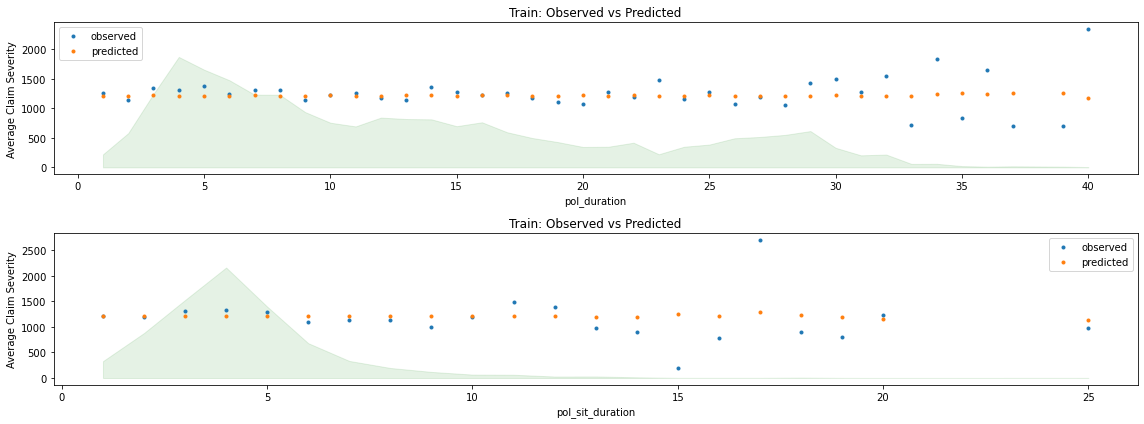

In [64]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

major.plot(feature="pol_duration",
    weight="year",
    observed="claim_amount",
    y_label="Average Claim Severity",
    ax=ax[0])

major.plot(feature="pol_sit_duration",
    weight="year",
    observed="claim_amount",
    y_label="Average Claim Severity",
    ax=ax[1])

plt.tight_layout()

(array([17., 11., 12.,  6., 17., 10., 14., 18., 18., 28., 38., 39., 41.,
        31., 19., 20., 17.,  9.,  8.,  8.,  2.,  4.,  1.,  3.,  2.,  0.,
         6.,  1.,  2.,  1.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.43820742e+00, 6.28420994e+01, 1.24245991e+02, 1.85649883e+02,
        2.47053775e+02, 3.08457667e+02, 3.69861559e+02, 4.31265451e+02,
        4.92669343e+02, 5.54073235e+02, 6.15477127e+02, 6.76881019e+02,
        7.38284911e+02, 7.99688803e+02, 8.61092695e+02, 9.22496587e+02,
        9.83900479e+02, 1.04530437e+03, 1.10670826e+03, 1.16811215e+03,
        1.22951605e+03, 1.29091994e+03, 1.35232383e+03, 1.41372772e+03,
  

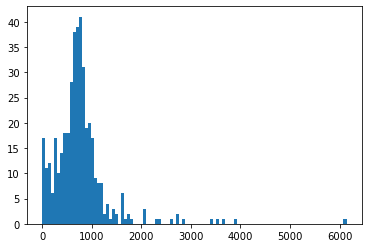

In [65]:
plt.hist(major.test.join(major.results).groupby('vh_make_model')['Residuals_Squared'].mean(), bins=100)

In [51]:
# A new dataframe with residual data from past models
major_with_vh_dataset = major.test.join(major.results)[['vh_make_model', 'claim_amount','Predictions', 'Residuals', 'Residuals_Squared']]

# Data processing
major_with_vh_dataset.reset_index(inplace=True, drop=True)

# One hot encoding the make/model strings
dummy_vh_make_model = get_dummies(major_with_vh_dataset['vh_make_model'])
major_with_vh_dataset = major_with_vh_dataset.join(dummy_vh_make_model)

# Classifying the residual column
# To round to nearest 1 to try and force multiclass y
major_with_vh_dataset['Residuals_classed'] = [int(x) for x in major_with_vh_dataset['Residuals']]

features = [*dummy_vh_make_model.columns]



In [52]:
major_with_vh_model = tree.DecisionTreeClassifier()
major_with_vh = ClaimModel( major_with_vh_model, major_with_vh_dataset, target='Residuals_classed', features=features)

major_with_vh.fit()
major_with_vh.predict()
major_with_vh.results.mean()

Actual                  6.620690
Predictions         -1381.340818
Residuals           -1387.961508
Residuals_Squared    1980.014435
dtype: float64

In [53]:
major_with_vh.results.head(50)

,Actual,Predictions,Residuals,Residuals_Squared
1794,-4988,-2926,2062,2062.0
2590,-1231,-3654,-2423,2423.0
984,-112,-6186,-6074,6074.0
3737,-78,-2415,-2337,2337.0
3074,595,733,138,138.0
4420,815,-1068,-1883,1883.0
3443,167,-551,-718,718.0
35,804,-906,-1710,1710.0
2527,71,-113,-184,184.0
4428,682,-2807,-3489,3489.0


In [54]:
claims_ultra['claim_amount'].sum()

1373107.2599999998

In [56]:
len(raw_data)

228216

In [57]:
1373107/228216

6.0166990920881975